In [11]:
!pip install opencv-python mediapipe matplotlib numpy

In [12]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [13]:
mp_pose = mp.solutions.pose
mp_draw = mp.solutions.drawing_utils

pose = mp_pose.Pose(
    static_image_mode=False,
    min_detection_confidence=0.6,
    min_tracking_confidence=0.6
)

I0000 00:00:1758430084.630897  176846 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2


In [14]:
def calculate_angle(a, b, c):
    """Calculate angle between three points"""
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    if angle > 180.0:
        angle = 360 - angle
    return angle


In [15]:
def analyze_video(video_path, category_name, save_output=False):
    cap = cv2.VideoCapture(video_path)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = int(cap.get(cv2.CAP_PROP_FPS))
    
    if save_output:
        out = cv2.VideoWriter(f"{category_name}_pose.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    joint_angles = defaultdict(list)
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(rgb_frame)
        
        if result.pose_landmarks:
            mp_draw.draw_landmarks(frame, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)
            landmarks = result.pose_landmarks.landmark
            
            # Example: track elbow and knee angles
            left_elbow_angle = calculate_angle(
                [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                 landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y],
                [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                 landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y],
                [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,
                 landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
            )
            right_knee_angle = calculate_angle(
                [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,
                 landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y],
                [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,
                 landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y],
                [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,
                 landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
            )
            
            joint_angles['left_elbow'].append(left_elbow_angle)
            joint_angles['right_knee'].append(right_knee_angle)
            
            # Display angles on frame
            cv2.putText(frame, str(int(left_elbow_angle)), 
                        (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)
            cv2.putText(frame, str(int(right_knee_angle)), 
                        (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)
        
        cv2.imshow(f'{category_name} Pose', frame)
        if save_output:
            out.write(frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    if save_output:
        out.release()
    cv2.destroyAllWindows()
    
    return joint_angles


In [16]:
categories = {
    "Basketball": "Videos/basketball.mp4",
    "Basketball2": "Videos/basketball2.mp4",
    "Boxing": "Videos/boxing.mp4",
    "Football": "Videos/football.mp4",
    "Athletics": "Videos/athletics.mp4"
}

In [17]:
all_data = {}

for cat, vid_path in categories.items():
    print(f"Analyzing {cat} video...")
    angles = analyze_video(vid_path, category_name=cat, save_output=True)
    all_data[cat] = angles


W0000 00:00:1758430084.786715  194922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1758430084.800539  194921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Analyzing Basketball video...


/opt/anaconda3/envs/pose_env/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Analyzing Basketball2 video...
Analyzing Boxing video...
Analyzing Football video...
Analyzing Athletics video...


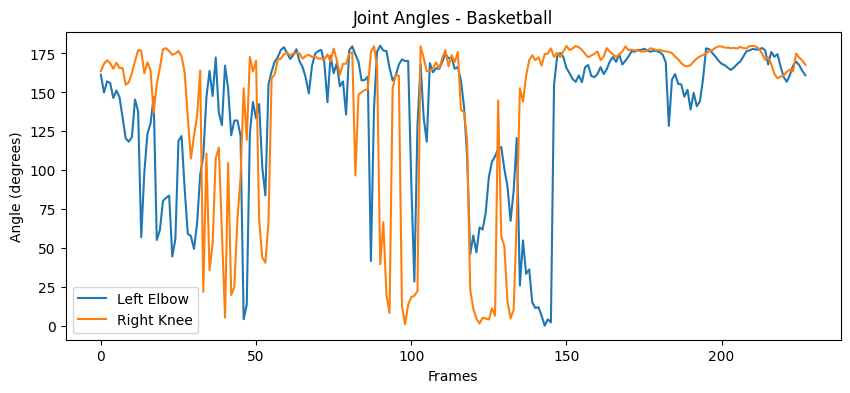

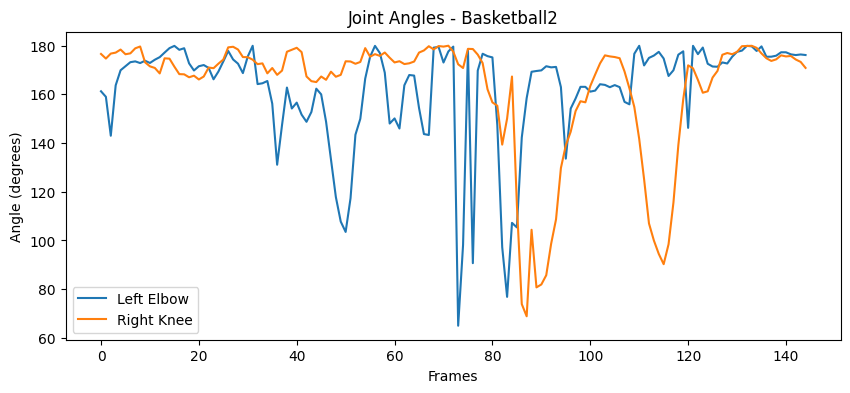

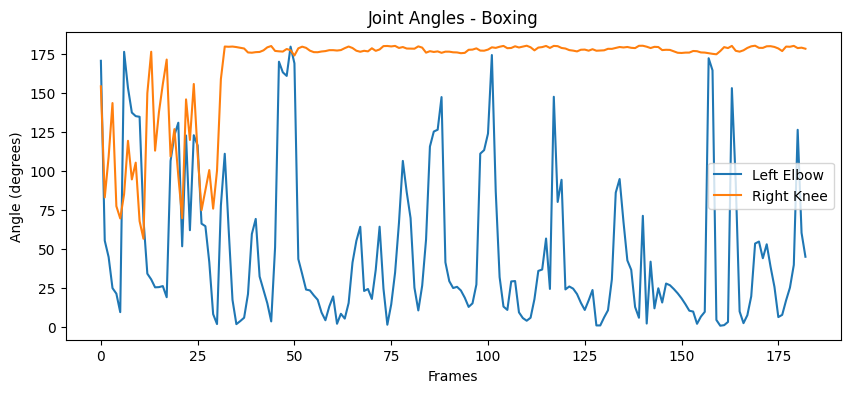

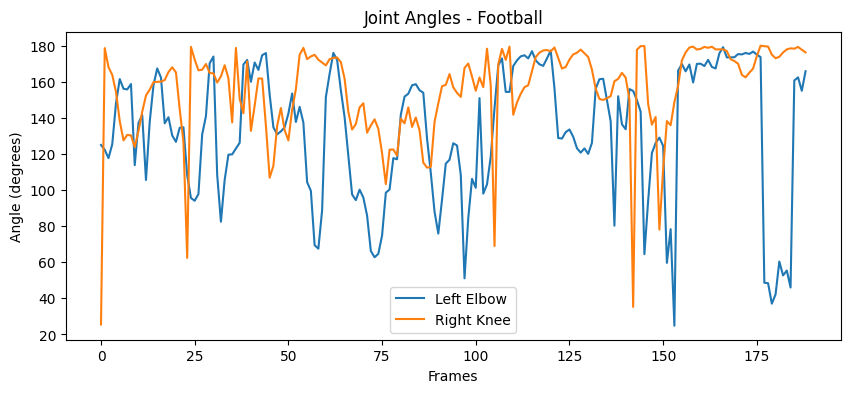

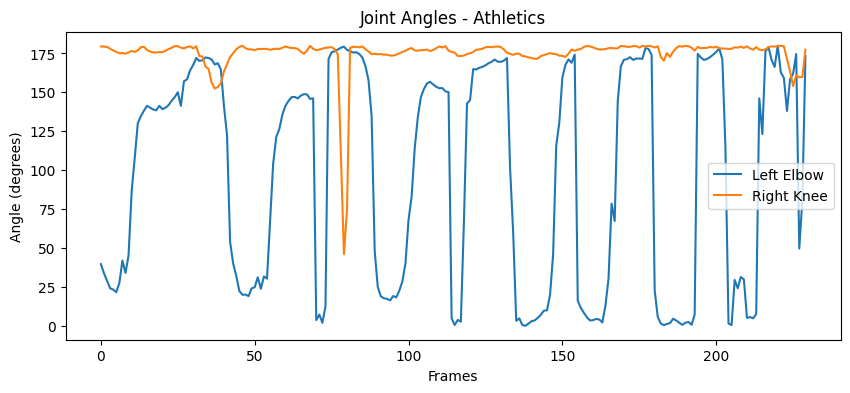

In [18]:
for cat, data in all_data.items():
    plt.figure(figsize=(10,4))
    plt.plot(data['left_elbow'], label='Left Elbow')
    plt.plot(data['right_knee'], label='Right Knee')
    plt.title(f'Joint Angles - {cat}')
    plt.xlabel('Frames')
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.show()